# 1. Загрузка данных

In [1004]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [1005]:
# Настройка отображения графиков
%matplotlib inline
pd.set_option("display.max_columns", None)

data_path = Path("data/cian_rentals.jsonl")

df = pd.read_json(data_path, lines=True)

print(f"Загружено записей: {len(df)}")

Загружено записей: 14062


In [1006]:
df.head()

,url,title,price_per_month,price_currency,cian_estimated_price,address,metro_count,metro_nearest_time,total_area,floor,facts,features,parsed_at
0,https://spb.cian.ru/rent/flat/325755125/?mlSea...,"Сдаются 2-комн. апартаменты, 35 м²",55000.0,RUB,NaN,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",2026-01-26 21:06:47.114500
1,https://spb.cian.ru/rent/flat/324842491/?mlSea...,"Сдаются 5-комн. апартаменты, 200 м²",200000.0,RUB,NaN,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],2026-01-26 21:06:50.615774
2,https://spb.cian.ru/rent/flat/326049379/?mlSea...,"Сдается студия, 15 м²",20500.0,RUB,NaN,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",2026-01-26 21:06:57.151698
3,https://spb.cian.ru/rent/flat/319887249/?mlSea...,"Сдается апартаменты-студия, 22 м²",33990.0,RUB,NaN,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",2026-01-26 21:07:01.557419
4,https://spb.cian.ru/rent/flat/325556962/?mlSea...,"Сдается апартаменты-студия, 14,1 м²",27000.0,RUB,NaN,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",2026-01-26 21:07:05.661957


In [1007]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 14062 entries, 0 to 14061
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   url                   14062 non-null  str           
 1   title                 14062 non-null  str           
 2   price_per_month       13517 non-null  float64       
 3   price_currency        14062 non-null  str           
 4   cian_estimated_price  0 non-null      float64       
 5   address               14062 non-null  str           
 6   metro_count           14062 non-null  int64         
 7   metro_nearest_time    14062 non-null  str           
 8   total_area            14062 non-null  str           
 9   floor                 14062 non-null  str           
 10  facts                 14062 non-null  object        
 11  features              14062 non-null  object        
 12  parsed_at             14062 non-null  datetime64[us]
dtypes: datetime64[us](1), float

# 2. Очистка данных
### 2.1. Априори ненужные или null-поля

In [1008]:
df.drop(columns=["url", "cian_estimated_price", "parsed_at"], inplace=True)
df.head()

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
0,"Сдаются 2-комн. апартаменты, 35 м²",55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,"Сдаются 5-комн. апартаменты, 200 м²",200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,"Сдается студия, 15 м²",20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,"Сдается апартаменты-студия, 22 м²",33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,"Сдается апартаменты-студия, 14,1 м²",27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


## 2.2. Записи, которые не были спаршены из-за антибот проверок

In [1009]:
df[df["title"].str.contains("VPN")]

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
6018,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6020,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6021,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6023,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6024,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
...,...,...,...,...,...,...,...,...,...,...
12192,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
12193,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
12195,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
12196,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]


In [1010]:
df = df[~df["title"].str.contains("VPN")]
df[df["title"].str.contains("VPN")]

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features


In [1011]:
df = df.drop(columns=["title"])

## 2.3. Null записи

In [1012]:
df.info()

<class 'pandas.DataFrame'>
Index: 13519 entries, 0 to 14061
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_per_month     13517 non-null  float64
 1   price_currency      13519 non-null  str    
 2   address             13519 non-null  str    
 3   metro_count         13519 non-null  int64  
 4   metro_nearest_time  13519 non-null  str    
 5   total_area          13519 non-null  str    
 6   floor               13519 non-null  str    
 7   facts               13519 non-null  object 
 8   features            13519 non-null  object 
dtypes: float64(1), int64(1), object(2), str(5)
memory usage: 1.0+ MB


In [1013]:
df[df["price_per_month"].isna()]

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
4993,NaN,RUB,,0,,,,{},[]
11855,NaN,RUB,,0,,,,{},[]


In [1014]:
df.dropna(inplace=True)
df.info()

<class 'pandas.DataFrame'>
Index: 13517 entries, 0 to 14061
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_per_month     13517 non-null  float64
 1   price_currency      13517 non-null  str    
 2   address             13517 non-null  str    
 3   metro_count         13517 non-null  int64  
 4   metro_nearest_time  13517 non-null  str    
 5   total_area          13517 non-null  str    
 6   floor               13517 non-null  str    
 7   facts               13517 non-null  object 
 8   features            13517 non-null  object 
dtypes: float64(1), int64(1), object(2), str(5)
memory usage: 1.0+ MB


In [1015]:
df.head()

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
0,55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


## 2.4. Выделение фич и фактов в отдельные фреймы, чистка дубликатов

In [1016]:
facts_df = pd.json_normalize(df["facts"])
features_df = pd.get_dummies(df["features"].explode()).groupby(level=0).sum()

In [1017]:
facts_df

,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг
0,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN
3,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN
4,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14057,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN
14058,3 000 ₽ (без счётчиков),33 000 ₽,60%,1 месяц,от года,NaN,27 м²,NaN,NaN,5 из 18,NaN,Смежная/Изолированная,1 совмещенный,NaN,Косметический,1 пассажирский,NaN,NaN,NaN,NaN,2023,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 балкон,NaN,NaN,NaN,NaN
14059,4 000 ₽ (без счётчиков),34 500 ₽,NaN,1 месяц,от года,NaN,18 м²,11 м²,3 м²,12 из 23,NaN,NaN,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",NaN,Подземная,NaN,"2,85 м",2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN
14060,включена (без счётчиков),15 000 ₽,50%,1 месяц,несколько месяцев,можно с детьми,"54,2 м²",34 м²,10 м²,3 из 5,NaN,NaN,NaN,Во двор,Косметический,1 пассажирский,Монолитный,Наземная,NaN,NaN,2011,NaN,Железобетонные,4,Центральное,Нет,NaN,NaN,1 балкон,NaN,NaN,NaN,NaN


In [1018]:
features_df

,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,0,1,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,1,0,1,1,1
3,1,1,1,0,1,1,1,1,1,1
4,0,1,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
14057,1,0,1,0,1,1,0,1,0,1
14058,0,0,0,0,1,1,0,1,1,1
14059,0,1,0,0,1,1,0,1,0,1
14060,1,0,0,0,1,1,0,1,1,1


In [1019]:
df = df.drop(columns=["facts", "features"])
df

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor
0,55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21
1,200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5
2,20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4
3,33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11
4,27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2
...,...,...,...,...,...,...,...
14057,30000.0,RUB,"Санкт-Петербург, р-н Калининский, Академическо...",3,5 мин,32 м²,5 из 10
14058,33000.0,RUB,"Санкт-Петербург, р-н Василеостровский, Гавань,...",3,7 мин,27 м²,5 из 18
14059,31999.0,RUB,"Санкт-Петербург, р-н Невский, № 54, ул. Дыбенк...",3,6 мин,18 м²,12 из 23
14060,36000.0,RUB,"Санкт-Петербург, р-н Пушкинский, мкр. Шушары, ...",3,19 мин,"54,2 м²",3 из 5


In [1020]:
df_clean = df.join([facts_df, features_df], how="inner")
df_clean

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1
1,200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
3,33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1
4,27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14057,30000.0,RUB,"Санкт-Петербург, р-н Калининский, Академическо...",3,5 мин,32 м²,5 из 10,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,1
14058,33000.0,RUB,"Санкт-Петербург, р-н Василеостровский, Гавань,...",3,7 мин,27 м²,5 из 18,3 000 ₽ (без счётчиков),33 000 ₽,60%,1 месяц,от года,NaN,27 м²,NaN,NaN,5 из 18,NaN,Смежная/Изолированная,1 совмещенный,NaN,Косметический,1 пассажирский,NaN,NaN,NaN,NaN,2023,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 балкон,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,1,1,1
14059,31999.0,RUB,"Санкт-Петербург, р-н Невский, № 54, ул. Дыбенк...",3,6 мин,18 м²,12 из 23,4 000 ₽ (без счётчиков),34 500 ₽,NaN,1 месяц,от года,NaN,18 м²,11 м²,3 м²,12 из 23,NaN,NaN,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",NaN,Подземная,NaN,"2,85 м",2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,0,1,0,0,1,1,0,1,0,1
14060,36000.0,RUB,"Санкт-Петербург, р-н Пушкинский, мкр. Шушары, ...",3,19 мин,"54,2 м²",3 из 5,включена (без счётчиков),15 000 ₽,50%,1 месяц,несколько месяцев,можн

In [1021]:
duplicates = df_clean[df_clean.duplicated(keep="first")]
print(f"Количество полных дубликатов: {len(duplicates)}")
print(f"Всего данных: {len(df_clean)}")

Количество полных дубликатов: 12017
Всего данных: 13517


In [1022]:
df_clean = df_clean.drop_duplicates(keep="first")
df_clean

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1
1,200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
3,33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1
4,27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000.0,RUB,"Санкт-Петербург, р-н Московский, Звёздное, Пул...",3,16 мин,40 м²,17 из 22,не включена,35 000 ₽,100%,1 месяц,от года,NaN,40 м²,15 м²,10 м²,17 из 22,Апартаменты,Изолированная,1 совмещенный,NaN,Дизайнерский,"2 пассажирских, 2 грузовых",Монолитный,Наземная,NaN,3 м,2020,NaN,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
13858,30000.0,RUB,"Санкт-Петербург, р-н Калининский, Академическо...",3,5 мин,32 м²,5 из 10,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,1
13890,32000.0,RUB,"Санкт-Петербург, р-н Московский, Пулковский ме...",3,15 мин,36 м²,3 из 5,4 000 ₽ (без счётчиков),32 000 ₽,70%,1 месяц,от года,можно с детьми,36 м²,16 м²,9 м²,3 из 5,NaN,NaN,1 совмещенный,NaN,Евроремонт,1 грузовой,Монолитный,Наземная,NaN,NaN,2022,Индивидуальный проект,Железобетонные,15,Центральное,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,0,0,1,1,0,1,0,1
13903,33000.0,RUB,"Санкт-Петербург, р-н Приморский, Юнтолово, алл...",3,11 мин,25 м²,6 из 12,3 000 ₽ (без счётчиков),30 000 ₽,NaN,1 месяц,несколько месяцев,NaN,25 м²,20 м²,NaN,6 из 12,Na

In [1023]:
df = df_clean.copy()

In [1024]:
df.info()

<class 'pandas.DataFrame'>
Index: 1500 entries, 0 to 13995
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_per_month        1500 non-null   float64
 1   price_currency         1500 non-null   str    
 2   address                1500 non-null   str    
 3   metro_count            1500 non-null   int64  
 4   metro_nearest_time     1500 non-null   str    
 5   total_area             1500 non-null   str    
 6   floor                  1500 non-null   str    
 7   Оплата ЖКХ             1500 non-null   str    
 8   Залог                  1500 non-null   str    
 9   Комиссия               996 non-null    str    
 10  Предоплата             1441 non-null   str    
 11  Срок аренды            1500 non-null   str    
 12  Условия проживания     861 non-null    str    
 13  Общая площадь          1500 non-null   str    
 14  Жилая площадь          1199 non-null   str    
 15  Площадь кухни      

## 2.5. Анализ отдельных полей на их необходимость
### 2.5.1. Простые проверки на логичность данных

In [1025]:
df["price_currency"].unique().tolist()

['RUB']

т.е. всего 1 валюта => колонка **price_currency** бесполезна

In [1026]:
df["metro_count"].value_counts()

metro_count
3    1479
0      16
2       3
1       2
Name: count, dtype: int64

т.е. всего 21 значение, отличных от абсолютного большинства (меньше 1%) => колонка **metro_count** бесполезна

In [1027]:
np.modf(df["price_per_month"])[0].unique()

array([0.])

т.е. содержит только целочисленные значения => колонка **price_per_month** м.б. приведена к целому

In [1028]:
df = df.drop(columns=["price_currency", "metro_count"])
df["price_per_month"] = df["price_per_month"].astype(int)

In [1029]:
df.head()

,price_per_month,address,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,55000,"Санкт-Петербург, р-н Московский, Гагаринское, ...",1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1
1,200000,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,20500,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
3,33990,"Санкт-Петербург, р-н Выборгский, Светлановское...",11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1
4,27000,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1


### 2.5.2. Районы, кварталы...

In [1030]:
df["address"].str.contains("Санкт-Петербург")

0        True
1        True
2        True
3        True
4        True
         ... 
13837    True
13858    True
13890    True
13903    True
13995    True
Name: address, Length: 1500, dtype: bool

In [1031]:
df["address"] = df["address"].str.replace("Санкт-Петербург, ", "")
df.head()

,price_per_month,address,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,55000,"р-н Московский, Гагаринское, Витебский просп.,...",1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1
1,200000,"р-н Адмиралтейский, Адмиралтейский, наб. Реки ...",19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,20500,"р-н Адмиралтейский, Коломна, Витебская ул., 5/6",4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1
3,33990,"р-н Выборгский, Светлановское, Политехническая...",11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1
4,27000,"р-н Центральный, Лиговка-Ямская, Лиговский про...",7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1


In [1032]:
df["city_district"] = df["address"].str.split(", ").str[0].str.replace("р-н ", "")
df = df.drop(columns=["address"])

df.head()

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Адмиралтейский
2,20500,4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Адмиралтейский
3,33990,11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный


In [1033]:
df["city_district"].value_counts()

city_district
Приморский              223
Выборгский              157
Красногвардейский       133
Московский              130
Невский                 120
Красносельский          117
Центральный             106
Пушкинский               78
Василеостровский         77
Петроградский            76
Калининский              71
Адмиралтейский           66
Фрунзенский              56
Кировский                31
Петродворцовый           22
Колпинский               19
Курортный                11
Кронштадтский             4
Херсонский проезд         1
ул. Чекистов              1
ул. Верхне-Каменская      1
Name: count, dtype: int64

In [1034]:
top_7_districts = df["city_district"].value_counts().nlargest(7).index.tolist()

df["city_district"] = df["city_district"].apply(lambda x: x if x in top_7_districts else "Другой")

In [1035]:
df["city_district"].value_counts()

city_district
Другой               514
Приморский           223
Выборгский           157
Красногвардейский    133
Московский           130
Невский              120
Красносельский       117
Центральный          106
Name: count, dtype: int64

### 2.5.3. Время до метро

In [1036]:
len(df[~df["metro_nearest_time"].str.contains("мин")])

16

осталось 16 записей с пустым, но в то же время не-null metro_nearest_time. убираем их

In [1037]:
df = df[df["metro_nearest_time"].str.contains("мин")]

проверяем еще раз

In [1038]:
df[df["metro_nearest_time"].str.contains("мин")]

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1 мин,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19 мин,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4 мин,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11 мин,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7 мин,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16 мин,40 м²,17 из 22,не включена,35 000 ₽,100%,1 месяц,от года,NaN,40 м²,15 м²,10 м²,17 из 22,Апартаменты,Изолированная,1 совмещенный,NaN,Дизайнерский,"2 пассажирских, 2 грузовых",Монолитный,Наземная,NaN,3 м,2020,NaN,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Московский
13858,30000,5 мин,32 м²,5 из 10,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,1,Другой
13890,32000,15 мин,36 м²,3 из 5,4 000 ₽ (без счётчиков),32 000 ₽,70%,1 месяц,от года,можно с детьми,36 м²,16 м²,9 м²,3 из 5,NaN,NaN,1 совмещенный,NaN,Евроремонт,1 грузовой,Монолитный,Наземная,NaN,NaN,2022,Индивидуальный проект,Железобетонные,15,Центральное,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,0,0,1,1,0,1,0,1,Московский
13903,33000,11 мин,25 м²,6 из 12,3 000 ₽ (без счётчиков),30 000 ₽,NaN,1 месяц,несколько месяцев,NaN,25 м²,20 м²,NaN,6 из 12,NaN,Смежная,1 совмещенный,Во двор,Евроремонт,"1 пассажирский, 1 грузовой",NaN,Наземная,NaN,"2,7 м",2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Приморский


т.е. все значения в минутах => колонка **metro_nearest_time** м.б. приведена к целочисленному типу

In [1039]:
df["metro_nearest_time"] = df["metro_nearest_time"].str.replace(" мин", "").astype(int)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный


### 2.5.4. Жил-площадь

In [1040]:
df[df["total_area"].str.contains("м²")]

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35 м²,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200 м²,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15 м²,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22 м²,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,"14,1 м²",1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16,40 м²,17 из 22,не включена,35 000 ₽,100%,1 месяц,от года,NaN,40 м²,15 м²,10 м²,17 из 22,Апартаменты,Изолированная,1 совмещенный,NaN,Дизайнерский,"2 пассажирских, 2 грузовых",Монолитный,Наземная,NaN,3 м,2020,NaN,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Московский
13858,30000,5,32 м²,5 из 10,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,1,Другой
13890,32000,15,36 м²,3 из 5,4 000 ₽ (без счётчиков),32 000 ₽,70%,1 месяц,от года,можно с детьми,36 м²,16 м²,9 м²,3 из 5,NaN,NaN,1 совмещенный,NaN,Евроремонт,1 грузовой,Монолитный,Наземная,NaN,NaN,2022,Индивидуальный проект,Железобетонные,15,Центральное,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,0,0,1,1,0,1,0,1,Московский
13903,33000,11,25 м²,6 из 12,3 000 ₽ (без счётчиков),30 000 ₽,NaN,1 месяц,несколько месяцев,NaN,25 м²,20 м²,NaN,6 из 12,NaN,Смежная,1 совмещенный,Во двор,Евроремонт,"1 пассажирский, 1 грузовой",NaN,Наземная,NaN,"2,7 м",2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Приморский


т.е. все значения в квадратных метах => колонка **total_area** м.б. приведена к вещественному типу

In [1041]:
df["total_area"] = df["total_area"].str.replace(" м²", "").str.replace("\xa0м²", "").str.replace(",", ".").astype(float)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35.0,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200.0,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15.0,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22.0,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,14.1,1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный


### 2.5.5. Этажи

In [1042]:
df[df["floor"].str.contains("из")]

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35.0,11 из 21,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200.0,4 из 5,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15.0,1 из 4,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22.0,8 из 11,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,14.1,1 из 2,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16,40.0,17 из 22,не включена,35 000 ₽,100%,1 месяц,от года,NaN,40 м²,15 м²,10 м²,17 из 22,Апартаменты,Изолированная,1 совмещенный,NaN,Дизайнерский,"2 пассажирских, 2 грузовых",Монолитный,Наземная,NaN,3 м,2020,NaN,Нет информации,NaN,Нет информации,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Московский
13858,30000,5,32.0,5 из 10,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,32 м²,19 м²,8 м²,5 из 10,NaN,NaN,1 раздельный,NaN,Косметический,1 пассажирский,Панельный,Наземная,NaN,NaN,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,Центральное,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,1,Другой
13890,32000,15,36.0,3 из 5,4 000 ₽ (без счётчиков),32 000 ₽,70%,1 месяц,от года,можно с детьми,36 м²,16 м²,9 м²,3 из 5,NaN,NaN,1 совмещенный,NaN,Евроремонт,1 грузовой,Монолитный,Наземная,NaN,NaN,2022,Индивидуальный проект,Железобетонные,15,Центральное,Нет,NaN,NaN,1 лоджия,NaN,NaN,NaN,NaN,1,0,0,0,1,1,0,1,0,1,Московский
13903,33000,11,25.0,6 из 12,3 000 ₽ (без счётчиков),30 000 ₽,NaN,1 месяц,несколько месяцев,NaN,25 м²,20 м²,NaN,6 из 12,NaN,Смежная,1 совмещенный,Во двор,Евроремонт,"1 пассажирский, 1 грузовой",NaN,Наземная,NaN,"2,7 м",2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Приморский


т.е. все значения содержат этаж x из y => колонка **floor** м.б. трансформирована в дробную запись в диапазоне [0; 1]

In [1043]:
df["floor"] = df["floor"].str.split(" из ").apply(lambda x: float(x[0]) / float(x[1])).round(2)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35.0,0.52,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200.0,0.80,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15.0,0.25,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22.0,0.73,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,14.1,0.50,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный


### 2.5.6. Фичи!
#### 2.5.6.1. Общий анализ

In [1044]:
df.info()

<class 'pandas.DataFrame'>
Index: 1484 entries, 0 to 13995
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_per_month        1484 non-null   int64  
 1   metro_nearest_time     1484 non-null   int64  
 2   total_area             1484 non-null   float64
 3   floor                  1484 non-null   float64
 4   Оплата ЖКХ             1484 non-null   str    
 5   Залог                  1484 non-null   str    
 6   Комиссия               985 non-null    str    
 7   Предоплата             1430 non-null   str    
 8   Срок аренды            1484 non-null   str    
 9   Условия проживания     853 non-null    str    
 10  Общая площадь          1484 non-null   str    
 11  Жилая площадь          1190 non-null   str    
 12  Площадь кухни          1109 non-null   str    
 13  Этаж                   1484 non-null   str    
 14  Тип жилья              151 non-null    str    
 15  Планировка         

сразу удаляем колонки, данные о которых уже знаем

In [1045]:
df = df.drop(columns=["Общая площадь", "Этаж"])

также удалим сразу те колонки, данных о которых очень мало

In [1046]:
df = df.drop(
    columns=[
        "Тип жилья",
        "Планировка",
        "Вид из окон",
        "Предоплаты",
        "Высота потолков",
        "Газоснабжение",
        "Комиссии",
        "Спальных мест",
        "Придомовая территория",
        "Торг",
    ]
)

In [1047]:
df.info()

<class 'pandas.DataFrame'>
Index: 1484 entries, 0 to 13995
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_per_month       1484 non-null   int64  
 1   metro_nearest_time    1484 non-null   int64  
 2   total_area            1484 non-null   float64
 3   floor                 1484 non-null   float64
 4   Оплата ЖКХ            1484 non-null   str    
 5   Залог                 1484 non-null   str    
 6   Комиссия              985 non-null    str    
 7   Предоплата            1430 non-null   str    
 8   Срок аренды           1484 non-null   str    
 9   Условия проживания    853 non-null    str    
 10  Жилая площадь         1190 non-null   str    
 11  Площадь кухни         1109 non-null   str    
 12  Санузел               1395 non-null   str    
 13  Ремонт                1444 non-null   str    
 14  Количество лифтов     1197 non-null   str    
 15  Тип дома              947 non-null  

In [1048]:
df

,price_per_month,metro_nearest_time,total_area,floor,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Жилая площадь,Площадь кухни,Санузел,Ремонт,Количество лифтов,Тип дома,Парковка,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Балкон/лоджия,О подъезде,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district
0,55000,1,35.0,0.52,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,20 м²,10 м²,1 совмещенный,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,1,1,1,1,Московский
1,200000,19,200.0,0.80,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,NaN,"22,7 м²",NaN,Евроремонт,NaN,Панельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,Другой
2,20500,4,15.0,0.25,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,NaN,NaN,1 совмещенный,Косметический,NaN,Кирпичный,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Другой
3,33990,11,22.0,0.73,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,NaN,NaN,1 совмещенный,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,2019,NaN,Нет информации,NaN,Нет информации,Нет,1 лоджия,NaN,1,1,1,0,1,1,1,1,1,1,Выборгский
4,27000,7,14.1,0.50,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"11,1 м²",3 м²,1 совмещенный,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,1,0,1,1,1,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16,40.0,0.77,не включена,35 000 ₽,100%,1 месяц,от года,NaN,15 м²,10 м²,1 совмещенный,Дизайнерский,"2 пассажирских, 2 грузовых",Монолитный,Наземная,2020,NaN,Нет информации,NaN,Нет информации,Нет,1 лоджия,NaN,0,1,1,0,1,1,0,1,1,1,Московский
13858,30000,5,32.0,0.50,5 500 ₽ (без счётчиков),30 000 ₽,70%,1 месяц,от года,NaN,19 м²,8 м²,1 раздельный,Косметический,1 пассажирский,Панельный,Наземная,1975,1ЛГ-504,Нет информации,4,Центральное,Нет,1 лоджия,NaN,1,0,1,0,1,1,0,1,0,1,Другой
13890,32000,15,36.0,0.60,4 000 ₽ (без счётчиков),32 000 ₽,70%,1 месяц,от года,можно с детьми,16 м²,9 м²,1 совмещенный,Евроремонт,1 грузовой,Монолитный,Наземная,2022,Индивидуальный проект,Железобетонные,15,Центральное,Нет,1 лоджия,NaN,1,0,0,0,1,1,0,1,0,1,Московский
13903,33000,11,25.0,0.50,3 000 ₽ (без счётчиков),30 000 ₽,NaN,1 месяц,несколько месяцев,NaN,20 м²,NaN,1 совмещенный,Евроремонт,"1 пассажирский, 1 грузовой",NaN,Наземная,2024,Индивидуальный проект,Нет информации,NaN,Нет информации,Нет,1 лоджия,NaN,0,1,1,0,1,1,1,1,1,1,Приморский


#### 2.5.6.2. Анализ отдельных фич
##### 2.5.6.2.1. Оплата ЖКХ

In [1049]:
df["Оплата ЖКХ"].value_counts().sample(40)

Оплата ЖКХ
500 ₽ (без счётчиков)             2
30 000 ₽ (без счётчиков)          5
3 000 ₽ (без счётчиков)         186
3 100 ₽ (без счётчиков)           1
3 800 ₽ (без счётчиков)           2
3 000 ₽ (счётчики включены)       4
3 500 ₽ (счётчики включены)       3
3 300 ₽ (без счётчиков)           1
4 900 ₽ (без счётчиков)           2
21 500 ₽ (без счётчиков)          1
2 800 ₽ (без счётчиков)           3
2 700 ₽ (счётчики включены)       1
6 000 ₽ (без счётчиков)          51
5 300 ₽ (без счётчиков)           2
2 500 ₽ (без счётчиков)          66
4 200 ₽ (без счётчиков)           2
40 000 ₽ (без счётчиков)          1
7 600 ₽ (без счётчиков)           1
5 000 ₽ (счётчики включены)      26
15 000 ₽ (счётчики включены)      2
6 900 ₽ (без счётчиков)           1
700 ₽ (без счётчиков)             1
5 500 ₽ (без счётчиков)          13
3 500 ₽ (без счётчиков)          93
3 800 ₽ (счётчики включены)       1
5 000 ₽ (без счётчиков)         187
8 500 ₽ (без счётчиков)           7
1 500 ₽ (без счёт

Оплата ЖКХ:
1. включена (без счетчиков) - входит в стоимость аренды, плата переменная (=услуги=0, ~счетчики)
2. не включена - полностью зависит от использования услуг арендатором, плата переменная (~услуги, ~счетчики)
3. x рублей (без счетчиков) - x рублей, сверху только счетчики, плата переменная (=услуги, ~счетчики)
4. x рублей (счетчики включены) - x рублей, плата фиксированная (=услуги, =счетчики=0)

Для потенциальной модели можно разложить в следующие столбцы:
1. `utility_fixed_bill [int]`: Фиксированная сумма оплаты из строки. Если плата "не включена" => ставим 0
2. `utility_usage_bill_flg [bool]`: 1, если вся квитанция платится арендатором за фактическое потребление ("не включена")
3. `utility_counters_extra_flg [bool]`: 1, если счетчики оплачиваются сверху (варианты "без счётчиков" и "не включена")

In [1050]:
df["utility_fixed_bill"] = df["Оплата ЖКХ"].str.extract(r"(\d+ \d+)")[0].str.replace(" ", "").fillna("0").astype(int)
df["utility_usage_bill_flg"] = df["Оплата ЖКХ"].str.contains("не включена").astype(int)
df["utility_counters_extra_flg"] = (
    df["Оплата ЖКХ"].apply(lambda x: "не включена" in x or "без счётчиков" in x).astype(int)
)

df = df.drop(columns=["Оплата ЖКХ"])

##### 2.5.6.2.2. Залог

In [1051]:
facts_df["Залог"].value_counts()

Залог
30 000 ₽     1353
20 000 ₽      915
50 000 ₽      731
35 000 ₽      705
18 000 ₽      636
             ... 
52 000 ₽        1
99 000 ₽        1
135 000 ₽       1
88 000 ₽        1
790 800 ₽       1
Name: count, Length: 138, dtype: int64

In [1052]:
df["deposit"] = df["Залог"].apply(
    lambda x: int("".join(re.findall(r"\d+", x))) if any(char.isdigit() for char in x) else 0
)
df = df.drop(columns=["Залог"])

##### 2.5.6.2.3. Комиссия

In [1053]:
df["Комиссия"].value_counts()

Комиссия
50%     506
100%    168
60%      95
70%      90
80%      54
30%      15
40%      13
90%       6
35%       6
65%       4
20%       4
45%       3
75%       3
25%       3
55%       2
15%       2
79%       1
73%       1
59%       1
92%       1
33%       1
57%       1
88%       1
77%       1
72%       1
78%       1
43%       1
Name: count, dtype: int64

In [1054]:
df["comission"] = df["Комиссия"].str.replace("%", "").fillna("0").astype(float) / 100
df = df.drop(columns=["Комиссия"])

##### 2.5.6.2.4. Предоплата

In [1055]:
df["Предоплата"].value_counts()

Предоплата
1 месяц     1418
2 месяца      12
Name: count, dtype: int64

In [1056]:
df["prepayment_months_cnt"] = df["Предоплата"].str.replace(r"[^\d]", "", regex=True).fillna("0").astype(int)
df = df.drop(columns=["Предоплата"])

##### 2.5.6.2.5. Срок аренды

In [1057]:
df["Срок аренды"].value_counts()

Срок аренды
от года              1199
несколько месяцев     285
Name: count, dtype: int64

In [1058]:
df["rent_term_months_cnt"] = (
    df["Срок аренды"].fillna("помесячно").map({"от года": 12, "несколько месяцев": 3, "помесячно": 1}).astype(int)
)
df = df.drop(columns=["Срок аренды"])

##### 2.5.6.2.6. Условия проживания

In [1059]:
df["Условия проживания"].value_counts()

Условия проживания
можно с детьми                474
можно с детьми и животными    332
можно с животными              47
Name: count, dtype: int64

будет лучше удалить этот столбец т.к. непонятно, что делать с теми данными, в которых условий проживания не прописано

In [1060]:
df = df.drop(columns=["Условия проживания"])

##### 2.5.6.2.7. Санузел

In [1061]:
df["Санузел"].value_counts()

Санузел
1 совмещенный                  956
1 раздельный                   348
1 совмещенный, 1 раздельный     34
2 совмещенных                   34
2 раздельных                    11
2 совмещенных, 1 раздельный      8
3 совмещенных                    3
6 раздельных                     1
Name: count, dtype: int64

In [1062]:
df["combined_bathrooms_cnt"] = df["Санузел"].str.extract(r"(\d+)\s+совмещ")[0].fillna(0).astype(int)
df["separate_bathrooms_cnt"] = df["Санузел"].str.extract(r"(\d+)\s+раздел")[0].fillna(0).astype(int)
df = df.drop(columns=["Санузел"])

##### 2.5.6.2.8. Ремонт

In [1063]:
df["Ремонт"].value_counts()

Ремонт
Евроремонт       661
Косметический    426
Дизайнерский     344
Без ремонта       13
Name: count, dtype: int64

вероятнее всего, если информации о ремонте не указано, значит его нет! значит тут можно просто выполнить маппинг

In [1064]:
df["repair_cat"] = (
    df["Ремонт"]
    .fillna("Без ремонта")
    .map({"Без ремонта": 0, "Косметический": 1, "Евроремонт": 2, "Дизайнерский": 3})
)
df = df.drop(columns=["Ремонт"])

##### 2.5.6.2.9. Количество лифтов

In [1065]:
df["Количество лифтов"].value_counts()

Количество лифтов
1 пассажирский, 1 грузовой    415
1 пассажирский                264
2 пассажирских, 1 грузовой    121
2 пассажирских                118
2 пассажирских, 2 грузовых     57
1 грузовой                     56
3 пассажирских                 45
1 пассажирский, 2 грузовых     29
3 пассажирских, 1 грузовой     26
4 пассажирских, 1 грузовой     14
4 пассажирских                 11
4 пассажирских, 4 грузовых      8
3 пассажирских, 2 грузовых      6
3 пассажирских, 3 грузовых      6
4 пассажирских, 2 грузовых      5
2 грузовых                      4
4 грузовых                      4
5 пассажирских, 2 грузовых      3
3 грузовых                      2
2 пассажирских, 3 грузовых      1
1 пассажирский, 3 грузовых      1
5 пассажирских, 1 грузовой      1
Name: count, dtype: int64

In [1066]:
df["freight_elevators_cnt"] = df["Количество лифтов"].str.extract(r"(\d+)\s+груз")[0].fillna(0).astype(int)
df["passenger_elevators_cnt"] = df["Количество лифтов"].str.extract(r"(\d+)\s+пас")[0].fillna(0).astype(int)
df = df.drop(columns=["Количество лифтов"])

##### 2.5.6.2.10. Парковка

In [1067]:
df["Парковка"].value_counts()

Парковка
Наземная          707
Подземная         239
Открытая          125
Многоуровневая     29
Name: count, dtype: int64

In [1068]:
df["parking_cat"] = (
    df["Парковка"].map({"Подземная": 2, "Многоуровневая": 2, "Наземная": 1, "Открытая": 1}).fillna(0).astype(int)
)

df = df.drop(columns=["Парковка"])

##### 2.5.6.2.11. Отопление

In [1069]:
df["Отопление"].value_counts()

Отопление
Центральное                      759
Нет информации                   343
Индивидуальный тепловой пункт    200
Автономная котельная              26
Котел/Квартирное отопление         3
Печь                               1
Name: count, dtype: int64

In [1070]:
df["heating_cat"] = (
    df["Отопление"]
    .map(
        {
            "Котел/Квартирное отопление": 3,
            "Индивидуальный тепловой пункт": 3,
            "Автономная котельная": 2,
            "Центральное": 1,
            "Печь": 1,
            "Нет информации": 0,
        }
    )
    .fillna(0)
    .astype(int)
)
df = df.drop(columns=["Отопление"])

##### 2.5.6.2.12. Балконы

In [1071]:
df["Балкон/лоджия"].value_counts()

Балкон/лоджия
1 лоджия               579
1 балкон               300
1 лоджия, 1 балкон      23
2 лоджии                12
2 балкона               10
3 лоджии                 2
1 лоджия, 2 балкона      1
3 балкона                1
Name: count, dtype: int64

In [1072]:
df["balcony_cnt"] = df["Балкон/лоджия"].str.extract(r"(\d+)\s+балк")[0].fillna(0).astype(int)
df["loggia_cnt"] = df["Балкон/лоджия"].str.extract(r"(\d+)\s+лодж")[0].fillna(0).astype(int)
df = df.drop(columns=["Балкон/лоджия"])

##### 2.5.6.2.13. Тип подъезда

In [1073]:
df["О\xa0подъезде"].value_counts()

О подъезде
Есть мусоропровод              161
Есть консьерж                   15
Есть мусоропровод, консьерж      4
Name: count, dtype: int64

In [1074]:
df["has_garbage_chute_flg"] = df["О\xa0подъезде"].str.contains("мусоропровод", na=False).astype(int)
df["has_concierge_flg"] = df["О\xa0подъезде"].str.contains("консьерж", na=False).astype(int)
df = df.drop(columns=["О\xa0подъезде"])

##### 2.5.6.2.14. Подъезды

In [1075]:
df["Подъезды"].value_counts()

Подъезды
4     142
1     114
3     102
2      90
5      88
6      88
7      73
8      52
9      43
10     35
12     33
11     30
13     24
17     19
14     18
20     15
15     10
19      7
22      6
31      6
18      6
21      5
16      4
46      4
26      3
48      3
23      2
28      2
32      1
38      1
25      1
Name: count, dtype: int64

In [1076]:
df["entrances_cnt"] = df["Подъезды"].fillna(0).astype(int)
df = df.drop(columns=["Подъезды"])

##### 2.5.6.2.15. Жил площадь, площадь кухни

будет лучше удалить эти колонки так как они будут коррелировать с общей площадью квартиры, а также в них не очень много непустых данныхх

In [1077]:
df = df.drop(columns=["Жилая площадь", "Площадь кухни"])

##### 2.5.6.2.16. Аварийность

In [1078]:
df["Аварийность"].value_counts()

Аварийность
Нет    1332
Name: count, dtype: int64

непонятная фича, которую лучше убрать

In [1079]:
df = df.drop(columns=["Аварийность"])

##### 2.5.6.2.17. Строительная серия

In [1080]:
df["Строительная серия"].value_counts()

Строительная серия
Индивидуальный проект    734
137                       19
ЛГ-600.11                  8
1-528КП                    8
1ЛГ-504                    7
1Лг-606-7а                 4
ЛГ-600                     4
1-528КП-41                 4
1-528КП-80Э                3
111-121                    2
Г-2И                       2
1Лг-502В-6                 1
ОД-4                       1
1-528                      1
1-527С                     1
1-507-5                    1
Г-5                        1
И-155                      1
1-335-30                   1
1-405                      1
1-507                      1
606.11                     1
137.11                     1
Name: count, dtype: int64

In [1081]:
df["individual_project_flg"] = df["Строительная серия"].str.contains("Индивидуа").astype(int)
df = df.drop(columns=["Строительная серия"])

##### 2.5.6.2.18. Тип дома, год постройки и тип перекрытий

Оставшиеся 3 фичи стоит рассматривать вместе, так как о них известно меньше всего данных

Сначала посмотрим на тип перекрытий:

In [1082]:
df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    922
Нет информации    356
Смешанные          42
Деревянные         12
Name: count, dtype: int64

In [1083]:
df["Тип перекрытий"] = df["Тип перекрытий"].fillna("Нет информации")

In [1084]:
df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    922
Нет информации    508
Смешанные          42
Деревянные         12
Name: count, dtype: int64

Теперь посмотрим на год постройки:

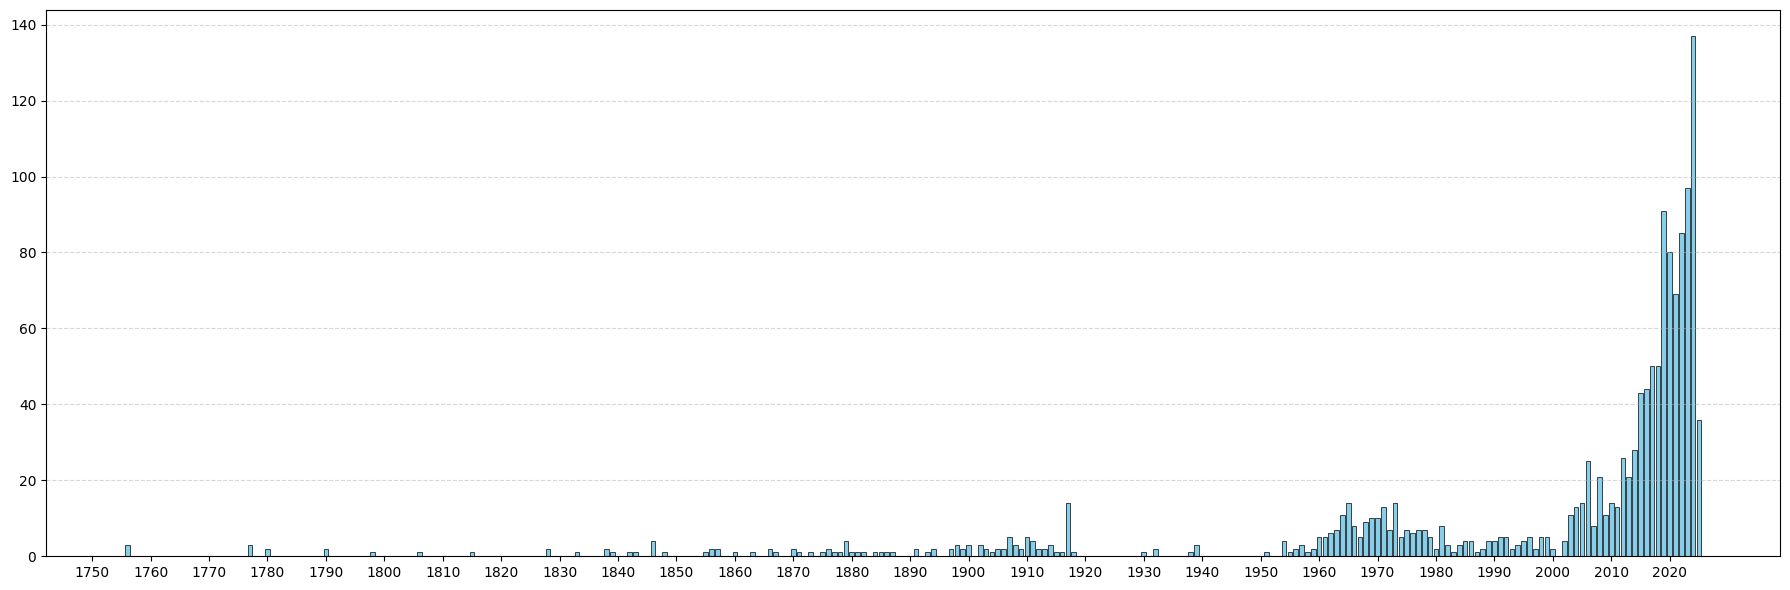

In [1085]:
counts = df["Год постройки"].dropna().astype(int).value_counts().sort_index()
years = counts.index
values = counts.values

fig, ax = plt.subplots(figsize=(18, 6))
bars = ax.bar(years, values, color="skyblue", edgecolor="black", linewidth=0.5, width=0.8)

min_year = int(years.min())
max_year = int(years.max())
start_tick = (min_year // 10) * 10
ticks = np.arange(start_tick, max_year + 1, 10)

ax.set_xticks(ticks)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

вероятно, наилучшим решением будет сгруппировать постройки по поколениям, так как данные распределены далеко не равномерно

In [1086]:
years = pd.to_numeric(df["Год постройки"], errors="coerce")

conditions = [
    (years <= 1917),  # дореволюционные
    (years > 1917) & (years <= 1991),  # советские
    (years > 1991) & (years <= 2013),  # постсоветские
    (years > 2013),  # современные
]

choices = range(1, len(conditions) + 1)  # 0 - нет информации

df["era_cat"] = np.select(conditions, choices, default=0).astype(int)
df = df.drop(columns=["Год постройки"])

In [1087]:
df["era_cat"].value_counts()

era_cat
4    810
2    224
3    214
1    123
0    113
Name: count, dtype: int64

теперь посмотрим на тип дома

In [1088]:
df["Тип дома"].value_counts()

Тип дома
Кирпичный              331
Монолитный             308
Панельный              168
Монолитно-кирпичный    109
Блочный                 31
Name: count, dtype: int64

во-первых, 31 блочных дома стоит объединить с панельными домами т.к по структуре они одинаковы

во-вторых, для типа дома не всегда понятно, как их ранжировать (кирпичный не всегда лучше деревянного), следовательно придется будет создавать dummy столбцы

в-третьих, надо понять, что делать с пропусками в данных. еще раз посмотрим на совокупность данных год постройки, тип дома и тип перекрытий

In [1089]:
df[["Тип перекрытий"]].value_counts()

Тип перекрытий
Железобетонные    922
Нет информации    508
Смешанные          42
Деревянные         12
Name: count, dtype: int64

In [1090]:
df["era_cat"].value_counts()

era_cat
4    810
2    224
3    214
1    123
0    113
Name: count, dtype: int64

необходимо заполнить всевозможные пропуски, основываясь на логике и здравом смысле

In [1091]:
# Объединяем Блочный с Панельными, так как они технологически близки
df["Тип дома"] = df["Тип дома"].replace("Блочный", "Панельный")

# Заменим отсутствие информации на nan
df["Тип перекрытий"] = df["Тип перекрытий"].replace("Нет информации", np.nan)

будем заполнять тип дома, основываясь на его годе сдачи

In [1092]:
df[["Тип перекрытий", "era_cat", "Тип дома"]].info()

<class 'pandas.DataFrame'>
Index: 1484 entries, 0 to 13995
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Тип перекрытий  976 non-null    str  
 1   era_cat         1484 non-null   int64
 2   Тип дома        947 non-null    str  
dtypes: int64(1), str(2)
memory usage: 46.4 KB


In [1093]:
def fill_house_type(row):
    if pd.notna(row["Тип дома"]):
        return row["Тип дома"]

    if row["era_cat"] == 4:
        return "Монолитно-кирпичный"  # Самый частый в новостройках
    if row["era_cat"] == 1:
        return "Кирпичный"  # Старый фонд
    if row["era_cat"] == 2:
        return "Панельный"  # Пик хрущевок
    return np.nan


df["Тип дома"] = df.apply(fill_house_type, axis=1)

In [1094]:
df["Тип дома"].info()

<class 'pandas.Series'>
Index: 1484 entries, 0 to 13995
Series name: Тип дома
Non-Null Count  Dtype
--------------  -----
1349 non-null   str  
dtypes: str(1)
memory usage: 23.2 KB


In [1095]:
df["Тип дома"].value_counts()

Тип дома
Монолитно-кирпичный    472
Кирпичный              342
Монолитный             308
Панельный              227
Name: count, dtype: int64

аналогично заполним тип перекрытий

In [1096]:
df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    922
Смешанные          42
Деревянные         12
Name: count, dtype: int64

In [1097]:
def fill_floors(row):
    if pd.notna(row["Тип перекрытий"]):
        return row["Тип перекрытий"]

    # 1. Все современные дома (era 3 и 4) и советские панели — это Ж/Б
    if row["era_cat"] >= 2:
        return "Железобетонные"

    # 2. В старом фонде (era 1), если инфо нет, смотрим на материал
    if row["era_cat"] == 1:
        if row["Тип дома"] == "Кирпичный":
            return "Смешанные"  # В старом кирпиче чаще всего смешанный тип

    return np.nan


df["Тип перекрытий"] = df.apply(fill_floors, axis=1)

In [1098]:
df["Тип перекрытий"].info()

<class 'pandas.Series'>
Index: 1484 entries, 0 to 13995
Series name: Тип перекрытий
Non-Null Count  Dtype
--------------  -----
1371 non-null   str  
dtypes: str(1)
memory usage: 23.2 KB


In [1099]:
df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    1311
Смешанные           48
Деревянные          12
Name: count, dtype: int64

объединим редкие классы в один

In [1100]:
df["Тип перекрытий"] = df["Тип перекрытий"].replace("Деревянные", "Смешанные")

In [1101]:
df[["Тип перекрытий", "era_cat", "Тип дома"]].info()

<class 'pandas.DataFrame'>
Index: 1484 entries, 0 to 13995
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Тип перекрытий  1371 non-null   str  
 1   era_cat         1484 non-null   int64
 2   Тип дома        1349 non-null   str  
dtypes: int64(1), str(2)
memory usage: 46.4 KB


In [1102]:
df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    1311
Смешанные           60
Name: count, dtype: int64

к сожалению, столбец тип перекрытий получился очень неинформативным, так что его стоит удалить

In [1103]:
df = df.drop(columns=["Тип перекрытий"])

In [1104]:
df["Тип дома"].value_counts()

Тип дома
Монолитно-кирпичный    472
Кирпичный              342
Монолитный             308
Панельный              227
Name: count, dtype: int64

In [1105]:
df["era_cat"].value_counts()

era_cat
4    810
2    224
3    214
1    123
0    113
Name: count, dtype: int64

удалим все записи, что не получилось заполнить данными

In [1106]:
df = df.dropna()

а также добавим dummy классы для типа дома для решения одной из вышеописанных проблем

In [1107]:
df["Тип дома"].value_counts()

Тип дома
Монолитно-кирпичный    472
Кирпичный              342
Монолитный             308
Панельный              227
Name: count, dtype: int64

In [1108]:
houst_material = df["Тип дома"].replace(
    {
        "Монолитно-кирпичный": "monolithic_brick",
        "Кирпичный": "brick",
        "Монолитный": "monolithic",
        "Панельный": "panel",
    }
)

house_dummies = pd.get_dummies(houst_material, dtype=int, drop_first=True).add_prefix("house_type_").add_suffix("_flg")
df = pd.concat([df, house_dummies], axis=1)
df = df.drop(columns=["Тип дома"])
df

,price_per_month,metro_nearest_time,total_area,floor,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник,city_district,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months_cnt,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_cat,freight_elevators_cnt,passenger_elevators_cnt,parking_cat,heating_cat,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,entrances_cnt,individual_project_flg,era_cat,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg
0,55000,1,35.0,0.52,0,1,1,0,1,1,1,1,1,1,Московский,10000,0,0,27500,0.5,1,12,1,0,2,1,2,2,0,0,0,0,0,0,0,0,0,1,0
1,200000,19,200.0,0.80,0,0,0,0,0,0,0,0,0,0,Другой,0,0,1,200000,0.5,0,12,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,20500,4,15.0,0.25,0,1,1,0,1,1,0,1,1,1,Другой,5500,0,1,20500,1.0,1,12,1,0,1,0,0,0,1,0,0,0,0,3,1,1,0,0,0
3,33990,11,22.0,0.73,1,1,1,0,1,1,1,1,1,1,Выборгский,3500,0,1,34000,0.0,1,3,1,0,2,2,2,2,0,0,1,0,0,0,0,4,1,0,0
5,44000,3,24.0,0.56,1,0,1,1,1,1,1,1,1,1,Другой,0,1,1,44000,0.0,0,3,0,0,0,1,1,1,0,0,1,0,0,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16,40.0,0.77,0,1,1,0,1,1,0,1,1,1,Московский,0,1,1,35000,1.0,1,12,1,0,3,2,2,1,0,0,1,0,0,0,0,4,1,0,0
13858,30000,5,32.0,0.50,1,0,1,0,1,1,0,1,0,1,Другой,5500,0,1,30000,0.7,1,12,0,1,1,0,1,1,1,0,1,0,0,4,0,2,0,0,1
13890,32000,15,36.0,0.60,1,0,0,0,1,1,0,1,0,1,Московский,4000,0,1,32000,0.7,1,12,1,0,2,1,0,1,1,0,1,0,0,15,1,4,1,0,0
13903,33000,11,25.0,0.50,0,1,1,0,1,1,1,1,1,1,Приморский,3000,0,1,30000,0.0,1,3,1,0,2,1,1,1,0,0,1,0,0,0,1,4,0,1,0


In [1109]:
df.info()

<class 'pandas.DataFrame'>
Index: 1349 entries, 0 to 13995
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price_per_month                  1349 non-null   int64  
 1   metro_nearest_time               1349 non-null   int64  
 2   total_area                       1349 non-null   float64
 3   floor                            1349 non-null   float64
 4   Ванна                            1349 non-null   int64  
 5   Душевая кабина                   1349 non-null   int64  
 6   Интернет                         1349 non-null   int64  
 7   Кондиционер                      1349 non-null   int64  
 8   Мебель в комнатах                1349 non-null   int64  
 9   Мебель на кухне                  1349 non-null   int64  
 10  Посудомоечная машина             1349 non-null   int64  
 11  Стиральная машина                1349 non-null   int64  
 12  Телевизор                        13

### 2.5.7. Флаги

In [1110]:
df = df.rename(
    columns={
        "Ванна": "has_bath_flg",
        "Душевая кабина": "has_shower_flg",
        "Интернет": "has_internet_flg",
        "Кондиционер": "has_ac_flg",
        "Мебель в комнатах": "has_room_furniture_flg",
        "Мебель на кухне": "has_kitchen_furniture_flg",
        "Посудомоечная машина": "has_dishwasher_flg",
        "Стиральная машина": "has_washer_flg",
        "Телевизор": "has_tv_flg",
        "Холодильник": "has_fridge_flg",
    }
)
df.info()

<class 'pandas.DataFrame'>
Index: 1349 entries, 0 to 13995
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price_per_month                  1349 non-null   int64  
 1   metro_nearest_time               1349 non-null   int64  
 2   total_area                       1349 non-null   float64
 3   floor                            1349 non-null   float64
 4   has_bath_flg                     1349 non-null   int64  
 5   has_shower_flg                   1349 non-null   int64  
 6   has_internet_flg                 1349 non-null   int64  
 7   has_ac_flg                       1349 non-null   int64  
 8   has_room_furniture_flg           1349 non-null   int64  
 9   has_kitchen_furniture_flg        1349 non-null   int64  
 10  has_dishwasher_flg               1349 non-null   int64  
 11  has_washer_flg                   1349 non-null   int64  
 12  has_tv_flg                       13

### 2.5.8. Преобразование районов в dummy

In [1111]:
df["city_district"].value_counts()

city_district
Другой               459
Приморский           202
Выборгский           138
Красногвардейский    124
Красносельский       114
Невский              112
Московский           110
Центральный           90
Name: count, dtype: int64

In [1112]:
district_dummies = (
    pd.get_dummies(
        df["city_district"].map(
            {
                "Другой": "other",
                "Приморский": "primorsky",
                "Выборгский": "vyborgsky",
                "Красногвардейский": "krasnogvardeysky",
                "Красносельский": "krasnoselsky",
                "Невский": "nevsky",
                "Московский": "moskovsky",
                "Центральный": "central",
            }
        ),
        dtype=int,
        drop_first=True,
    )
    .add_prefix("district_")
    .add_suffix("_flg")
)

df = pd.concat([df, district_dummies], axis=1)
df = df.drop(columns=["city_district"])
df.info()

<class 'pandas.DataFrame'>
Index: 1349 entries, 0 to 13995
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price_per_month                  1349 non-null   int64  
 1   metro_nearest_time               1349 non-null   int64  
 2   total_area                       1349 non-null   float64
 3   floor                            1349 non-null   float64
 4   has_bath_flg                     1349 non-null   int64  
 5   has_shower_flg                   1349 non-null   int64  
 6   has_internet_flg                 1349 non-null   int64  
 7   has_ac_flg                       1349 non-null   int64  
 8   has_room_furniture_flg           1349 non-null   int64  
 9   has_kitchen_furniture_flg        1349 non-null   int64  
 10  has_dishwasher_flg               1349 non-null   int64  
 11  has_washer_flg                   1349 non-null   int64  
 12  has_tv_flg                       13

In [1113]:
df

,price_per_month,metro_nearest_time,total_area,floor,has_bath_flg,has_shower_flg,has_internet_flg,has_ac_flg,has_room_furniture_flg,has_kitchen_furniture_flg,has_dishwasher_flg,has_washer_flg,has_tv_flg,has_fridge_flg,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months_cnt,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_cat,freight_elevators_cnt,passenger_elevators_cnt,parking_cat,heating_cat,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,entrances_cnt,individual_project_flg,era_cat,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg,district_krasnogvardeysky_flg,district_krasnoselsky_flg,district_moskovsky_flg,district_nevsky_flg,district_other_flg,district_primorsky_flg,district_vyborgsky_flg
0,55000,1,35.0,0.52,0,1,1,0,1,1,1,1,1,1,10000,0,0,27500,0.5,1,12,1,0,2,1,2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,200000,19,200.0,0.80,0,0,0,0,0,0,0,0,0,0,0,0,1,200000,0.5,0,12,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,20500,4,15.0,0.25,0,1,1,0,1,1,0,1,1,1,5500,0,1,20500,1.0,1,12,1,0,1,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,0,0,0,1,0,0
3,33990,11,22.0,0.73,1,1,1,0,1,1,1,1,1,1,3500,0,1,34000,0.0,1,3,1,0,2,2,2,2,0,0,1,0,0,0,0,4,1,0,0,0,0,0,0,0,0,1
5,44000,3,24.0,0.56,1,0,1,1,1,1,1,1,1,1,0,1,1,44000,0.0,0,3,0,0,0,1,1,1,0,0,1,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,35000,16,40.0,0.77,0,1,1,0,1,1,0,1,1,1,0,1,1,35000,1.0,1,12,1,0,3,2,2,1,0,0,1,0,0,0,0,4,1,0,0,0,0,1,0,0,0,0
13858,30000,5,32.0,0.50,1,0,1,0,1,1,0,1,0,1,5500,0,1,30000,0.7,1,12,0,1,1,0,1,1,1,0,1,0,0,4,0,2,0,0,1,0,0,0,0,1,0,0
13890,32000,15,36.0,0.60,1,0,0,0,1,1,0,1,0,1,4000,0,1,32000,0.7,1,12,1,0,2,1,0,1,1,0,1,0,0,15,1,4,1,0,0,0,0,1,0,0,0,0
13903,33000,11,25.0,0.50,0,1,1,0,1,1,1,1,1,1,3000,0,1,30000,0.0,1,3,1,0,2,1,1,1,0,0,1,0,0,0,1,4,0,1,0,0,0,0,0,0,1,0


### **💰 Финансовые показатели**

* `price_per_month`: Стоимость аренды в месяц.
* `deposit`: Сумма залога (депозита).
* `comission`: Комиссия агенту (в долях: например, 0.5 — это 50%).
* `prepayment_months_cnt`: Количество месяцев предоплаты при заезде.
* `utility_fixed_bill`: Фиксированная стоимость коммунальных платежей (если указана).
* `utility_usage_bill_flg`: Флаг, указывающий, что арендатор оплачивает эксплуатационные расходы (ЖКХ) отдельно.
* `utility_counters_extra_flg`: Флаг, указывающий, что счетчики (вода, свет) оплачиваются сверх аренды.

---

### **🏢 Характеристики квартиры и дома**

* `total_area`: Общая площадь квартиры (кв. м).
* `floor`: Этаж (в данном датасете представлен как **нормализованное значение**: отношение текущего этажа к общему числу этажей в доме).
* `rent_term_months_cnt`: Минимальный срок аренды в месяцах.
* `repair_cat`: Категория ремонта (уровень качества отделки).
* `era_cat`: Категория эпохи постройки (от дореволюционных до современных ЖК).
* `heating_cat`: Категория типа отопления.
* `individual_project_flg`: Флаг, указывающий на индивидуальный проект здания.
* `entrances_cnt`: Количество подъездов в доме.
* `house_type_..._flg`: Тип конструкции здания (бинарные флаги):
* `house_type_monolithic_flg`: Монолитный.
* `house_type_monolithic_brick_flg`: Кирпично-монолитный.
* `house_type_panel_flg`: Панельный.

---

### **📍 Расположение и Районы**

* `metro_nearest_time`: Время в пути до ближайшего метро (в минутах).
* `district_..._flg`: Принадлежность к административному району (One-Hot Encoding):
* `krasnogvardeysky`: Красногвардейский.
* `krasnoselsky`: Красносельский.
* `moskovsky`: Московский.
* `nevsky`: Невский.
* `primorsky`: Приморский.
* `vyborgsky`: Выборгский.
* `other`: Прочие районы.

---

### **🛁 Удобства и Санузлы**

* `combined_bathrooms_cnt`: Количество совмещенных санузлов.
* `separate_bathrooms_cnt`: Количество раздельных санузлов.
* `has_bath_flg`: Наличие ванны.
* `has_shower_flg`: Наличие душевой кабины.
* `balcony_cnt`: Количество балконов.
* `loggia_cnt`: Количество лоджий.

---

### **🛠 Инфраструктура и Оснащение**

* `passenger_elevators_cnt`: Количество пассажирских лифтов.
* `freight_elevators_cnt`: Количество грузовых лифтов.
* `parking_cat`: Категория доступности парковки.
* `has_garbage_chute_flg`: Наличие мусоропровода.
* `has_concierge_flg`: Наличие консьержа.

---

### **📺 Мебель и бытовая техника**

* `has_internet_flg`: Наличие интернета.
* `has_ac_flg`: Наличие кондиционера.
* `has_room_furniture_flg`: Наличие мебели в жилых комнатах.
* `has_kitchen_furniture_flg`: Наличие кухонного гарнитура.
* `has_dishwasher_flg`: Наличие посудомоечной машины.
* `has_washer_flg`: Наличие стиральной машины.
* `has_tv_flg`: Наличие телевизора.
* `has_fridge_flg`: Наличие холодильника.

In [1114]:
df.to_csv("data/cian_rentals_clean.csv", index=False, encoding="utf-8")

In [1115]:
df.to_json("data/cian_rentals_clean.json", index=False, orient="records", force_ascii=False, indent=4)